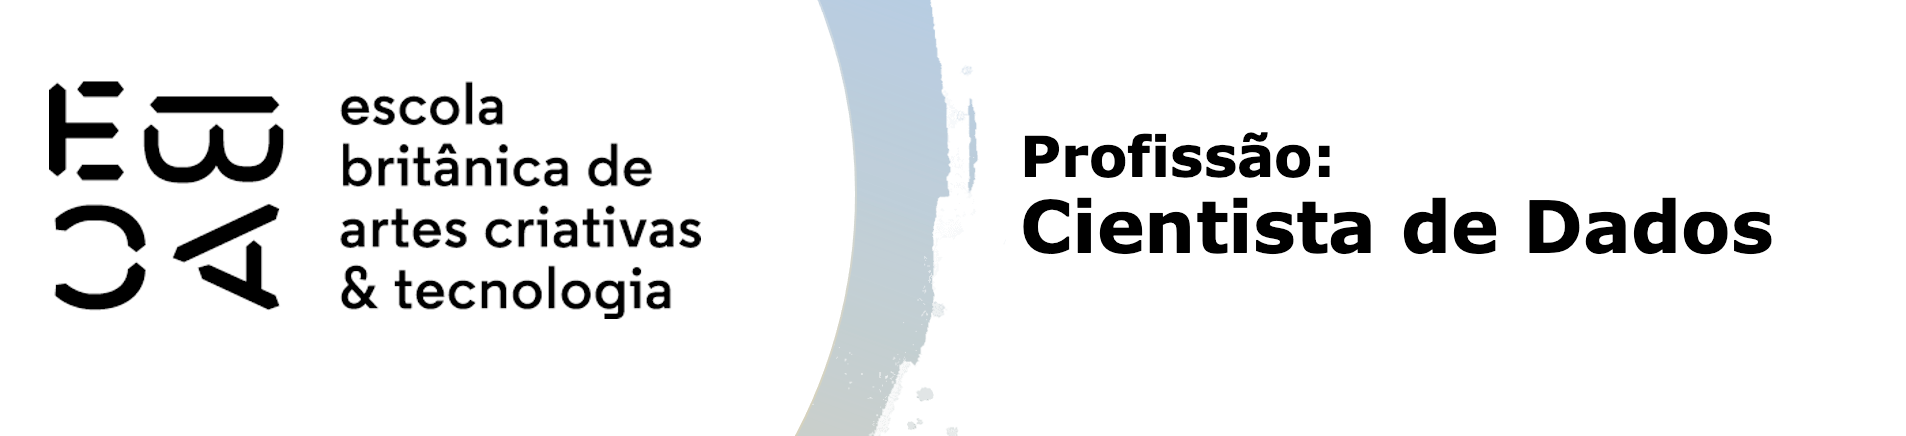

# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [50]:
%%time
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

CPU times: total: 0 ns
Wall time: 0 ns


In [51]:
df = pd.read_pickle('base_nfp.pkl')
df.head(3)

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes


## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [52]:
df['Dia da semana'] = df['Data Registro'].dt.day_name()
df['Dia do mês'] = df['Data Registro'].dt.day
df['Fim de semana'] = df['Data Registro'].dt.weekday.isin([5, 6]).astype(int)
df['Mês'] = df['Data Registro'].dt.month
df['Trimestre'] = df['Data Registro'].dt.quarter

df[['Dia da semana','Dia do mês', 'Fim de semana', 'Trimestre']].head(3)

,Dia da semana,Dia do mês,Fim de semana,Trimestre
0,Friday,30,0,2
1,Friday,30,0,2
2,Friday,30,0,2


In [53]:
df['Valor_NF_cat5']= pd.qcut(df['Valor NF'], 5, duplicates='drop', retbins=False)
df['Valor_NF_cat10']= pd.qcut(df['Valor NF'], 10, duplicates='drop', retbins=False)
df['Valor_NF_cat20']= pd.qcut(df['Valor NF'], 20, duplicates='drop', retbins=False)
df['Valor_NF_cat50']= pd.qcut(df['Valor NF'], 50, duplicates='drop', retbins=False)

df[['Valor NF','Valor_NF_cat5','Valor_NF_cat10','Valor_NF_cat20','Valor_NF_cat50']].sample(3)

,Valor NF,Valor_NF_cat5,Valor_NF_cat10,Valor_NF_cat20,Valor_NF_cat50
159795,37.11,"(28.61, 55.0]","(28.61, 38.88]","(32.9, 38.88]","(36.11, 38.88]"
117252,353.90,"(131.36, 562500.0]","(257.84, 562500.0]","(257.84, 441.28]","(310.854, 389.96]"
112000,631.69,"(131.36, 562500.0]","(257.84, 562500.0]","(441.28, 562500.0]","(510.586, 773.216]"


## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [54]:
metadados = pd.DataFrame({'dtype':df.dtypes})

metadados['papel'] = 'covariavel'
metadados.loc['flag_credito','papel'] = 'resposta'
metadados['nunique'] = df.nunique()
metadados

,dtype,papel,nunique
CNPJ emit.,object,covariavel,19606
Emitente,object,covariavel,15575
No.,int64,covariavel,124400
Data Emissão,datetime64[ns],covariavel,1815
Valor NF,float64,covariavel,33658
Data Registro,datetime64[ns],covariavel,1817
Créditos,float64,covariavel,9717
Situação do Crédito,category,covariavel,3
Ano,int64,covariavel,5
Semestre,int64,covariavel,2


In [55]:
%%time
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

iv = IV(df['categoria'], df.flag_credito)
iv

CPU times: total: 109 ms
Wall time: 105 ms


0.408312792227301

In [56]:
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'nunique']>1):
        
        metadados.loc[var, 'IV'] = IV(df[var], df.flag_credito)
    else: 
        print(f'else')
    
metadados

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, me

,dtype,papel,nunique,IV
CNPJ emit.,object,covariavel,19606,inf
Emitente,object,covariavel,15575,inf
No.,int64,covariavel,124400,inf
Data Emissão,datetime64[ns],covariavel,1815,inf
Valor NF,float64,covariavel,33658,inf
Data Registro,datetime64[ns],covariavel,1817,inf
Créditos,float64,covariavel,9717,inf
Situação do Crédito,category,covariavel,3,inf
Ano,int64,covariavel,5,0.041651
Semestre,int64,covariavel,2,0.001258


## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

**Resposta:**
Dentre as covariaveis a `categoria` se destaca com um IV de _0.408313_. Sobre a categorização da variável `Valor NF` o valor do IV sobe conforme o número de categorias aumenta.

## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

In [57]:
# Total de notas por trimestre
df.groupby('Trimestre').size()

Trimestre
1    36071
2    42622
3    54979
4    53974
dtype: int64

In [58]:
# df com a quantidade de notas por categoria e por período e proporção de notas com crédito
proporcao = df.groupby(['Trimestre', 'categoria']).agg(
    Total_Notas=('flag_credito', 'size'), 
    Notas_Com_Credito=('flag_credito', 'sum'))

proporcao['Proporcao_Com_Credito'] = proporcao['Notas_Com_Credito'] / proporcao['Total_Notas']
proporcao

Total_Notas  Notas_Com_Credito  Proporcao_Com_Credito
Trimestre categoria                                                          
1         Alimentos            3647               3208               0.879627
          Auto posto           1033                 54               0.052275
          Construção           7405               3031               0.409318
          Farmácia             3271                911               0.278508
          Mercado              9581               4207               0.439098
          Restaurantes         3710               1770               0.477089
          Varejo               1076                208               0.193309
          Vestuário             647                279               0.431221
          não definido         5701               2464               0.432205
2         Alimentos            4806               4253               0.884935
          Auto posto            630                 60               0.095238
          Construção           6449               2844               0.440999
          Farmácia             3660               1130               0.308743
          Mercado              9641               4347               0.450887
          Restaurantes         8951               3294               0.368004
          Varejo               1448                225               0.155387
          Vestuário             808                388               0.480198
          não definido         6229               2283               0.366511
3         Alimentos            3580               3046               0.850838
          Auto posto           1164                 89               0.076460
          Construção           8905               3262               0.366311
          Farmácia             3938               1320               0.335196
          Mercado             10450               5022               0.480574
          Restaurantes        16179               6819               0.421472
          Varejo               1583                282               0.178143
          Vestuário             955                547               0.572775
          não definido         8225               3646               0.443283
4         Alimentos            2927               2361               0.806628
          Auto posto            862                 68               0.078886
          Construção           9477               4674               0.493194
          Farmácia             4071               1525               0.374601
          Mercado             13023               6232               0.478538
          Restaurantes        10909               5235               0.479879
          Varejo               1797                320               0.178075
          Vestuário            1202                585               0.486689
          não definido         9706               4649               0.478982

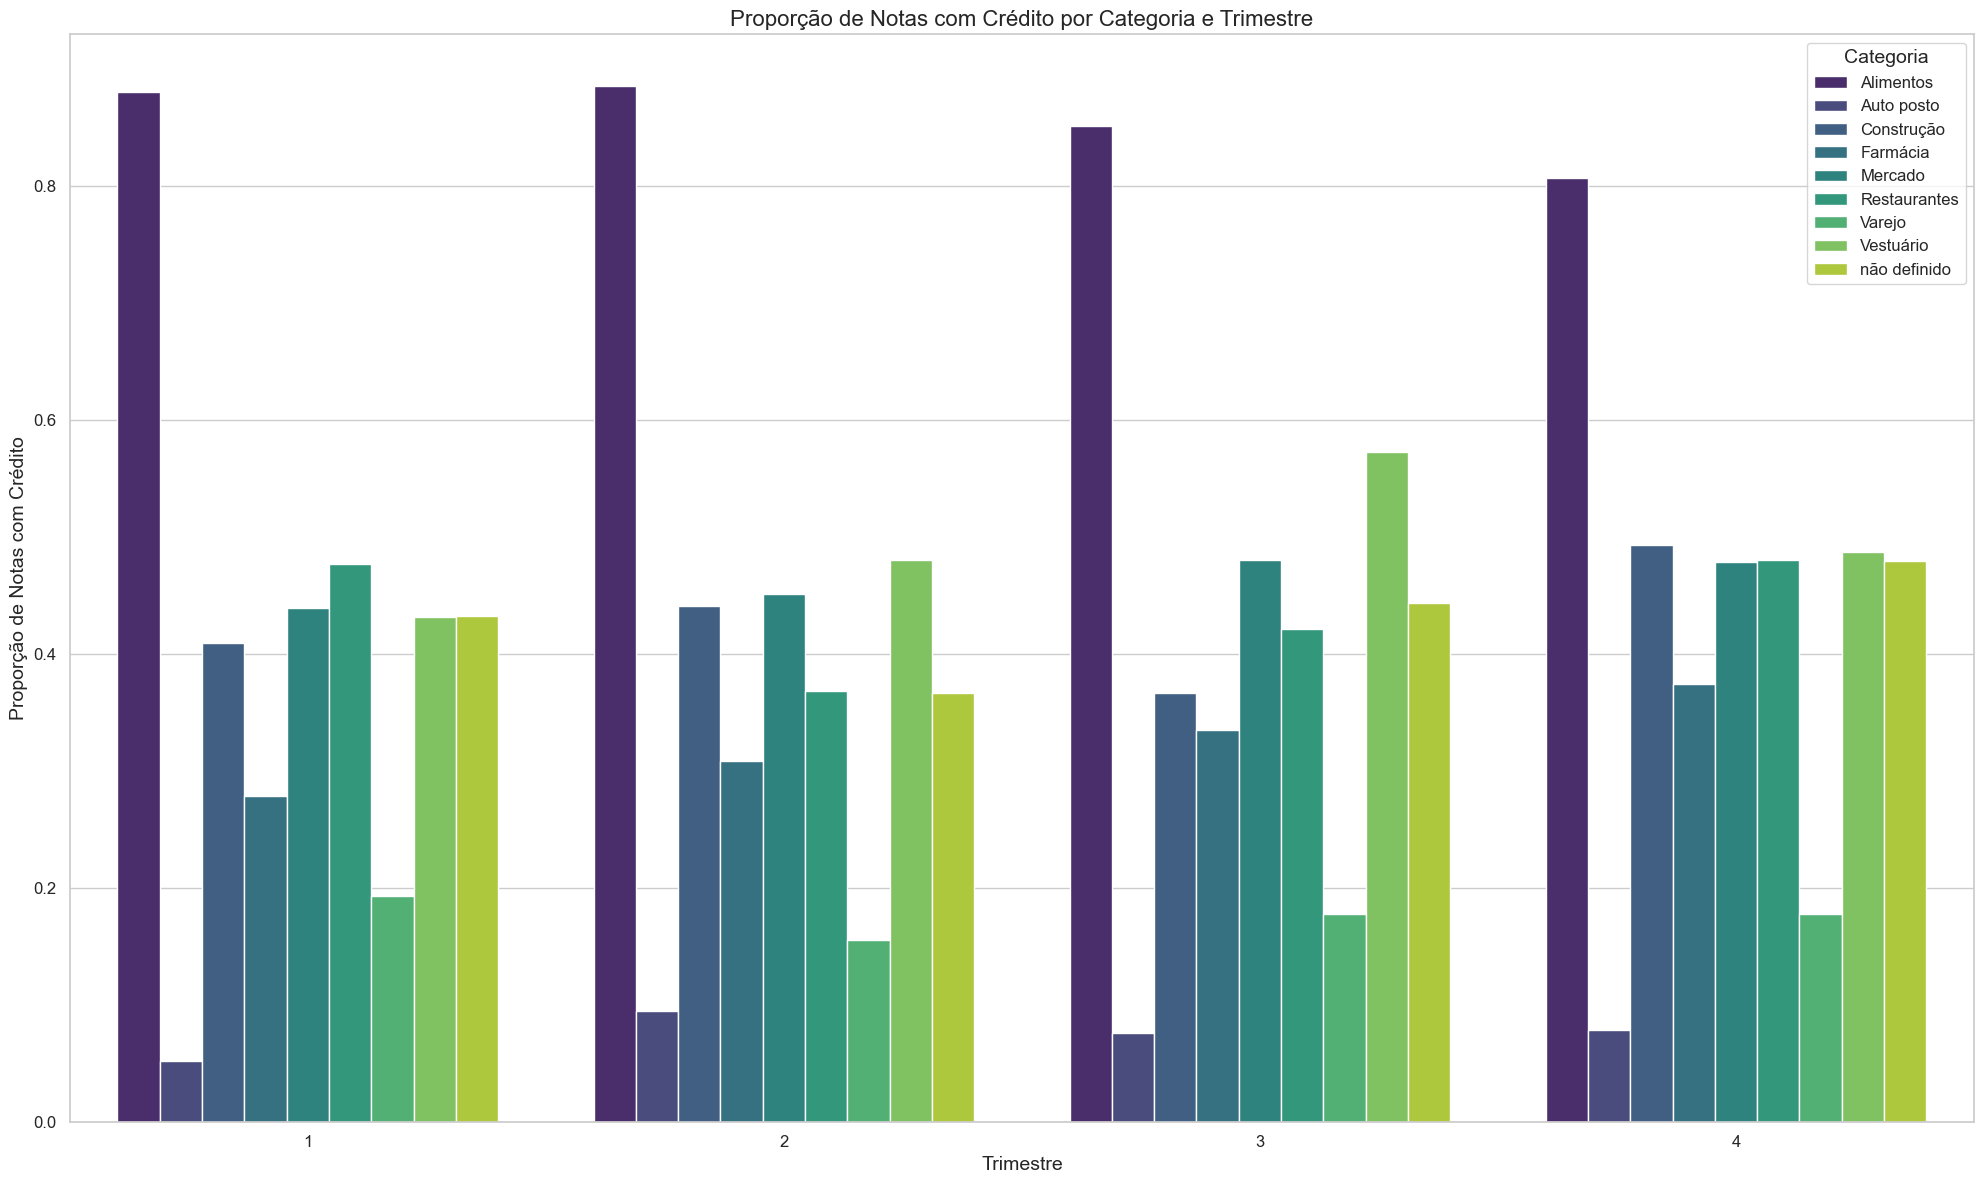

In [59]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(20, 12))
sns.barplot(
    data=proporcao, x="Trimestre", y="Proporcao_Com_Credito", hue="categoria", palette="viridis")

plt.title("Proporção de Notas com Crédito por Categoria e Trimestre", fontsize=16)
plt.xlabel("Trimestre", fontsize=14)
plt.ylabel("Proporção de Notas com Crédito", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Categoria", fontsize=12, title_fontsize=14)

plt.tight_layout()
plt.show()

## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

In [60]:
%%time
# função adaptada para incluir o ano como variável de tempo

def IV(variavel, resposta, ano):
    df_temp = pd.DataFrame({'variavel': variavel, 'resposta': resposta, 'ano': ano})
    
    tab = pd.crosstab([df_temp['ano'], df_temp['variavel']], df_temp['resposta'], margins=True, margins_name='total')
    tab.columns = ['0', '1', 'total']
    totals = tab.groupby('ano')[['0', '1']].sum()
    
    tab['pct_evento'] = tab['1'] / totals.loc[tab.index.get_level_values('ano'), '1'].values
    tab['pct_nao_evento'] = tab['0'] / totals.loc[tab.index.get_level_values('ano'), '0'].values

    tab['woe'] = np.log(tab['pct_evento'] / tab['pct_nao_evento'].replace(0, np.nan))
    tab['iv_parcial'] = (tab['pct_evento'] - tab['pct_nao_evento']) * tab['woe']

    tab = tab.drop(('total', 'total'), errors='ignore')
    
    iv_total = tab['iv_parcial'].sum()
    return tab, iv_total

tabela, iv_total = IV(df['categoria'], df['flag_credito'], df['Ano'])
print(iv_total)
tabela

3.436691233363992
CPU times: total: 297 ms
Wall time: 297 ms


0      1   total  pct_evento  pct_nao_evento  \
ano   variavel                                                          
2017  Alimentos         71   4875    4946    0.279883        0.002711   
      Auto posto      2480      9    2489    0.000517        0.094693   
      Construção      2712    505    3217    0.028993        0.103551   
      Farmácia        1609    343    1952    0.019692        0.061436   
      Mercado         2824   1084    3908    0.062234        0.107827   
      Restaurantes   15291   9482   24773    0.544379        0.583849   
      Varejo            66     11      77    0.000632        0.002520   
      Vestuário          7    163     170    0.009358        0.000267   
      não definido    1130    946    2076    0.054312        0.043146   
2018  Alimentos         97    227     324    0.046583        0.020438   
      Auto posto       194     23     217    0.004720        0.040877   
      Construção       382    447     829    0.091730        0.080489   
      Farmácia         134    220     354    0.045147        0.028234   
      Mercado         1777   2105    3882    0.431972        0.374421   
      Restaurantes    1316    934    2250    0.191668        0.277286   
      Varejo            73     32     105    0.006567        0.015381   
      Vestuário         36    318     354    0.065258        0.007585   
      não definido     737    567    1304    0.116355        0.155289   
2019  Alimentos        319   4324    4643    0.172760        0.014212   
      Auto posto       340    104     444    0.004155        0.015147   
      Construção      6808   5336   12144    0.213193        0.303306   
      Farmácia        1707    741    2448    0.029606        0.076049   
      Mercado         3907   3442    7349    0.137520        0.174062   
      Restaurantes    5472   5076   10548    0.202805        0.243785   
      Varejo           365    291     656    0.011627        0.016261   
      Vestuário        293    875    1168    0.034959        0.013054   
      não definido    3235   4840    8075    0.193376        0.144124   
2020  Alimentos        778   1720    2498    0.098207        0.031516   
      Auto posto       195     73     268    0.004168        0.007899   
      Construção      4262   3448    7710    0.196871        0.172648   
      Farmácia        3669   1213    4882    0.069259        0.148627   
      Mercado         7617   6182   13799    0.352975        0.308555   
      Restaurantes     237    953    1190    0.054414        0.009601   
      Varejo          1886    362    2248    0.020669        0.076400   
      Vestuário        657    202     859    0.011534        0.026614   
      não definido    5385   3361    8746    0.191904        0.218140   
2021  Alimentos        827   1722    2549    0.086952        0.033160   
      Auto posto       209     62     271    0.003131        0.008380   
      Construção      4261   4075    8336    0.205767        0.170850   
      Farmácia        2935   2369    5304    0.119622        0.117682   
      Mercado         6762   6995   13757    0.353211        0.271131   
      Restaurantes     315    673     988    0.033983        0.012630   
      Varejo          2479    339    2818    0.017118        0.099399   
      Vestuário        820    241    1061    0.012169        0.032879   
      não definido    6332   3328    9660    0.168047        0.253889   
total               103008  84638  187646    1.000000        1.000000   

                         woe  iv_parcial  
ano   variavel                            
2017  Alimentos     4.637069    1.285265  
      Auto posto   -5.210916    0.490743  
      Construção   -1.273010    0.094913  
      Farmácia     -1.137764    0.047494  
      Mercado      -0.549623    0.025059  
      Restaurantes -0.069996    0.002763  
      Varejo       -1.383886    0.002613  
      Vestuário     3.555714    0.032324  
      não definido  0.230143    0.002570  
2018  Alimentos     0.823831    0.021539  
    

C:\Users\User\AppData\Local\Temp\ipykernel_9972\4041092687.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tabela_iv_sem_vazio['Ano'] = tabela_iv_sem_vazio['Ano'].astype(int)


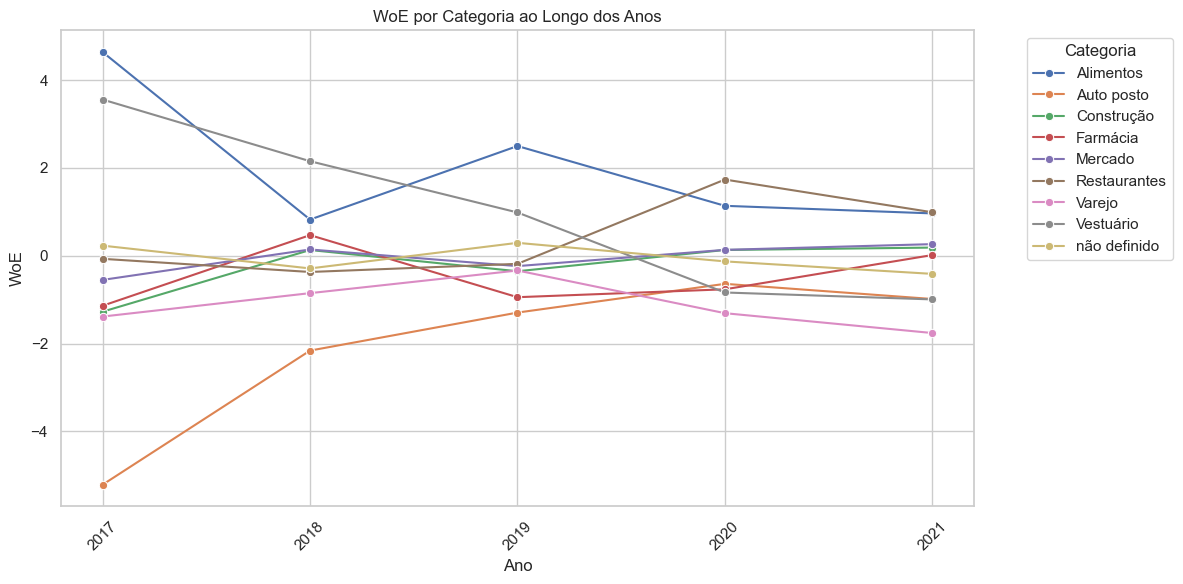

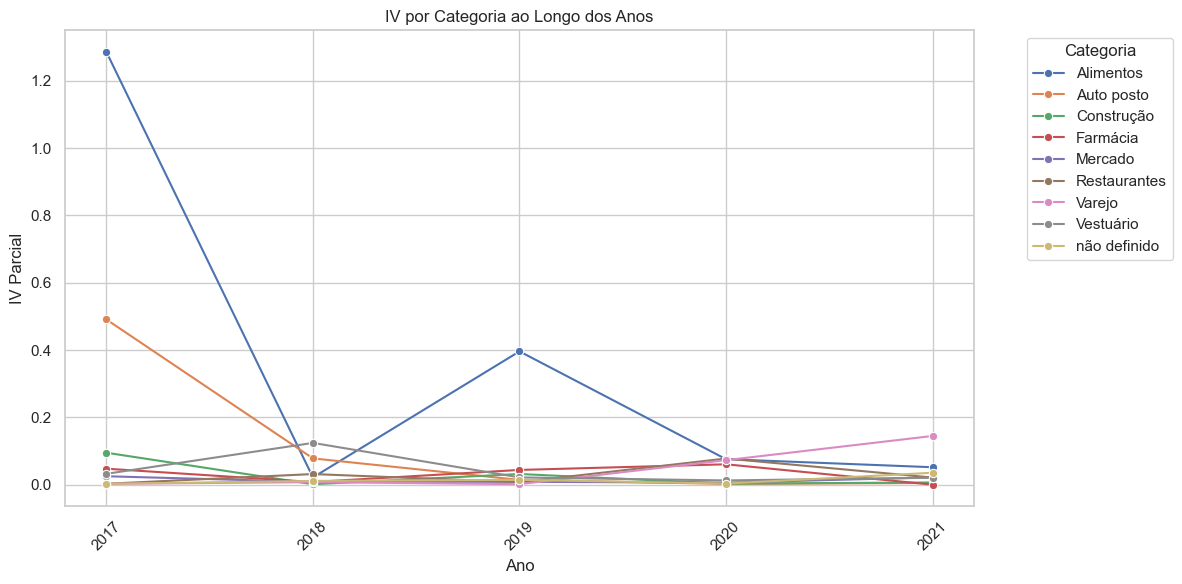

In [61]:
tabela.reset_index(inplace=True)
tabela.rename(columns={'ano': 'Ano', 'variavel': 'Categoria'}, inplace=True)

tabela_iv_sem_vazio = tabela[tabela['Categoria'] != '']
tabela_iv_sem_vazio['Ano'] = tabela_iv_sem_vazio['Ano'].astype(int)


"""Plot dos gráfico ao longo dos anos"""

plt.figure(figsize=(12, 6))
sns.lineplot(data=tabela_iv_sem_vazio, x='Ano', y='woe', hue='Categoria', marker='o')
plt.title('WoE por Categoria ao Longo dos Anos')
plt.xlabel('Ano')
plt.ylabel('WoE')
plt.xticks(ticks=tabela_iv_sem_vazio['Ano'].unique(), rotation=45)
plt.legend(title='Categoria', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
sns.lineplot(data=tabela_iv_sem_vazio, x='Ano', y='iv_parcial', hue='Categoria', marker='o')
plt.title('IV por Categoria ao Longo dos Anos')
plt.xlabel('Ano')
plt.ylabel('IV Parcial')
plt.xticks(ticks=tabela_iv_sem_vazio['Ano'].unique(), rotation=45)
plt.legend(title='Categoria', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

**Resposta:**
A categoria com mais notas com retorno maior que zero é Alimentos, mas houve queda. Vale acrescentar que considerando o ano de 2020 à 2021, o IV parcial para entender a probabilidade de retorno de crédito o **Varejo** se iguala a **Alimentos** em 2020, e em 2021 ultrapassa.